**Desarrollo**

# Predicción del nivel de ansiedad mediante análisis de texto

---

El presente trabajo pretende entrenar un modelo de clasificación, que a partir de el anásis de texto, determine el nivel de ansiedad de una persona.  

Se ha utilizado la base de datos [DAIC-WOZ](http://dcapswoz.ict.usc.edu/wwwutil_files/DAICWOZDepression_Documentation.pdf), de la Universidad del Sur de California, el mismo que fue generado mediante sesiones de una entrevista clínica y el cuestionario PHQ8 con 189 personas.  Las entrevista fue diseñada para el soporte al diagnóstico de condiciones de enfermedades sicológicas como ansiedad, depresión y desordenes de estrés post traumático.

Los datos del dataset incluyen grabaciones de audio de las entrevitas con sus correspondientes transcripciones asi como las caracterísicas faciales de los sujetos entrevistados.

Esta base de datos es parte de un corpus mas completo, Corpus de Entrevistas para el Análisis de Enfermedades, DAIC por sus siglas en inglés.  

La base de datos consiste en un comprimido para cada sesión de entrevistas, en la misma constan varios recursos de los cuales en este trabajo de ha hecho uso de la transcripción de la entrevista, como preparación previa se ha cargado todas las entrevistas en un único dataframe de forma local con el siguiente código.  

####Método de carga de transcripts

Al considerar tanto al entrevistador como al participante, el conjunto de datos se reduce a las sesiones de 186 personas, dado que 3 transcripciones no contienen el texto correspondiente a Ellie, la entrevistadora virtual. El csv generado se ha subido a google drive para poder utilizarlo en este lab.

In [0]:
"""
rows_list = []

for filename in glob.iglob('/Volumes/Dev/Projects/Psicobotica/**/*TRANSCRIPT.csv', recursive=True):    
    transcript = pd.read_csv(filename, sep='\t')    
    m = re.search('^\/(.+\/)*(\d+)_TRANSCRIPT.csv', filename)    
    personId = m.group(2)
    p = {}
    question = ""
    answer = ""
    lines = len(transcript)
    for i in range(0, lines): 
        row=transcript.iloc[i]
        if (row["speaker"] == "Ellie" ) or (i == lines - 1):
            p["personId"] = personId
            if ("(" in str(question)):
                question = question[question.index("(")+1:question.index(")")]
            p["question"] = question
            p["answer"] = answer
            if (question != ""):
                rows_list.append(p)
            p = {}         
            answer = ""
            question = row["value"]
        else:
            answer = str(answer) + " " + str(row["value"])
    
allParticipants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
allParticipants.to_csv('/Volumes/Dev/Projects/practicas/all.csv', sep=',')
"""

'\nrows_list = []\n\nfor filename in glob.iglob(\'/Volumes/Dev/Projects/Psicobotica/**/*TRANSCRIPT.csv\', recursive=True):    \n    transcript = pd.read_csv(filename, sep=\'\t\')    \n    m = re.search(\'^\\/(.+\\/)*(\\d+)_TRANSCRIPT.csv\', filename)    \n    personId = m.group(2)\n    p = {}\n    question = ""\n    answer = ""\n    lines = len(transcript)\n    for i in range(0, lines): \n        row=transcript.iloc[i]\n        if (row["speaker"] == "Ellie" ) or (i == lines - 1):\n            p["personId"] = personId\n            if ("(" in str(question)):\n                question = question[question.index("(")+1:question.index(")")]\n            p["question"] = question\n            p["answer"] = answer\n            if (question != ""):\n                rows_list.append(p)\n            p = {}         \n            answer = ""\n            question = row["value"]\n        else:\n            answer = str(answer) + " " + str(row["value"])\n    \nallParticipants = pd.DataFrame(rows_list,

####Instalo las librerias utilizadas

In [0]:
!pip install -q gensim

####Importo las librerias requeridas para el desarrollo del trabajo

In [0]:
import glob
import pandas as pd
import numpy as np
import re
import fnmatch
import os
import keras

from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Activation, GlobalAveragePooling1D, Flatten, Concatenate, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from scipy import stats

from keras.utils.vis_utils import plot_model

import matplotlib
import matplotlib.pyplot as plt

import itertools
import gensim
import nltk
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


Descargamos los recursos de nltk, wordnet y stopwords para el procesamiento de lenguaje natural

In [0]:
nltk.download('wordnet')
nltk.download('stopwords')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Habilito uso de drive para cargar los datasets

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


####Variable generales

En base a la clasificación propuesta en https://www.torbayandsouthdevon.nhs.uk/uploads/score-sheet-gad-7-anxiety-and-phq-9-depression.pdf, se definen 5 niveles de ansiedad basados en la puntuación PHQ8

In [0]:
labels=['none','mild','moderate','moderately severe', 'severe']
num_classes = len(labels)

####Funciones para gráficas de modelos

Tomadas de la materia Sistemas Cognitivos Artificiales - Alfredo Lainez

In [0]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Graph title", metric='acc'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

## Carga y preprocesamiento de transcripciones

#### Carga de fuentes de datos


---

Cargo el dataset que contiene solo las respuestas de los participantes

Cargo el transcript de la entrevistadora virtual y los participantes

In [0]:
all_participants = pd.read_csv('/content/drive/My Drive/Colab Notebooks/all.csv', sep=',')
all_participants.columns =  ['index','personId', 'question', 'answer']
all_participants = all_participants.astype({"index": float, "personId": float, "question": str, "answer": str })

Visualizo los primeros datos de los dataframes cargados.

In [0]:
all_participants.head()

,index,personId,question,answer
0,0.0,475.0,hi i'm ellie thanks for coming in today i was ...,yes
1,1.0,475.0,okay,nan
2,2.0,475.0,so how are you doing today,good thank you
3,3.0,475.0,that's good,nan
4,4.0,475.0,where are you from originally,el segundo right down the street


####Analisis de datos

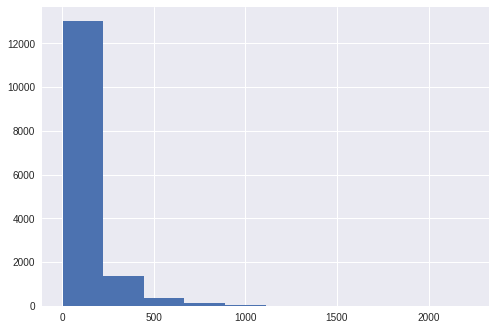

In [0]:
ds_len = len(all_participants)
len_answers = [len(v) for v in all_participants['answer']]
ds_max = max(len_answers)
ds_min = min(len_answers)

stats.describe(len_answers)
plt.hist(len_answers)
plt.show()

La mayor cantidad de frases tiene una longitud de 50 palabras

####Funciones auxiliares para procesamiento de texto

#####Función tomada de kaggle para limpieza de texto

In [0]:
# The function "text_to_wordlist" is from
# https://www.kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

Identificamos el número de palabras distintas

In [0]:
all_participants_mix = all_participants.copy()
all_participants_mix['answer'] = all_participants_mix.apply(lambda row: text_to_wordlist(row.answer).split(), axis=1)

In [0]:
words = [w for w in all_participants_mix['answer'].tolist()]
words = set(itertools.chain(*words))
vocab_size = len(words)

Preprocesamos los datos de entrada:


*   Limpieza de texto
*   Lematización
*   Separación en vectores



In [0]:
windows_size = 10
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_participants_mix['answer'])
tokenizer.fit_on_sequences(all_participants_mix['answer'])

all_participants_mix['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix['answer'])
all_participants_mix.head()

,index,personId,question,answer,t_answer
0,0.0,475.0,hi i'm ellie thanks for coming in today i was ...,[yes],[39]
1,1.0,475.0,okay,[],[]
2,2.0,475.0,so how are you doing today,"[good, thank]","[16, 173]"
3,3.0,475.0,that's good,[],[]
4,4.0,475.0,where are you from originally,"[el, segundo, right, street]","[2246, 4302, 47, 827]"


Verificamo el diccionario creado por el tokenizer

In [0]:
word_index = tokenizer.word_index
word_size = len(word_index)
print(word_index["happy"])

69


Generamos un nuevo dataset creando vectores de las palabras tokenizadas con un tamaño de ventana de 10 palabras

In [0]:
windows_size = 10
cont = 0
word_index = tokenizer
phrases_lp = pd.DataFrame(columns=['personId','answer', 't_answer'])
answers = all_participants_mix.groupby('personId').agg('sum', axis=1)

for p in answers.iterrows():      
    words = p[1]["answer"]
    size = len(words)
    word_tokens = p[1]["t_answer"]
 
    for i in range(size):
        sentence = words[i:min(i+windows_size,size)]  
        tokens = word_tokens[i:min(i+windows_size,size)]  
        phrases_lp.loc[cont] = [p[0], sentence, tokens]
        cont = cont + 1

Verificamos el contenido del nuevo dataset

In [0]:
phrases_lp.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, parent, um, love,...","[16, 1650, 2022, 1, 131, 1, 63, 5, 143, 5]"
1,300.0,"[atlanta, georgia, um, parent, um, love, like,...","[1650, 2022, 1, 131, 1, 63, 5, 143, 5, 337]"
2,300.0,"[georgia, um, parent, um, love, like, weather,...","[2022, 1, 131, 1, 63, 5, 143, 5, 337, 1]"
3,300.0,"[um, parent, um, love, like, weather, like, op...","[1, 131, 1, 63, 5, 143, 5, 337, 1, 39]"
4,300.0,"[parent, um, love, like, weather, like, opport...","[131, 1, 63, 5, 143, 5, 337, 1, 39, 1]"


En caso de existir frases de dimensión menor aplicamos padding para tener vectores uniformes

In [0]:
phrases_lp["t_answer"] = pad_sequences(phrases_lp["t_answer"], value=0, padding="post", maxlen=windows_size).tolist()
phrases_lp.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, parent, um, love,...","[16, 1650, 2022, 1, 131, 1, 63, 5, 143, 5]"
1,300.0,"[atlanta, georgia, um, parent, um, love, like,...","[1650, 2022, 1, 131, 1, 63, 5, 143, 5, 337]"
2,300.0,"[georgia, um, parent, um, love, like, weather,...","[2022, 1, 131, 1, 63, 5, 143, 5, 337, 1]"
3,300.0,"[um, parent, um, love, like, weather, like, op...","[1, 131, 1, 63, 5, 143, 5, 337, 1, 39]"
4,300.0,"[parent, um, love, like, weather, like, opport...","[131, 1, 63, 5, 143, 5, 337, 1, 39, 1]"


##Carga de resultados del cuestionario PHQ8 de los participantes

Preparo una función para cargar los archivos correspondientes a las puntuaciones de cada persona respecto al questionario PHQ8, este método categoriza la variable Score, en 5 niveles de acuerdo al rango especificado en el trabajo [Validity of a Brief Depression Severity Measure](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1495268/)

In [0]:
def load_avec_dataset_file(path, score_column):
  ds = pd.read_csv(path, sep=',')
  ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])
  ds['PHQ8_Score'] = ds[score_column]
  ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist()
  ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
  ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
  return ds

Cargo el dataset que contiene los resultados PHQ8 de todos los participantes, los datos han sido separados en archivos correspondientes a Train, Dev y Test.

In [0]:
train = load_avec_dataset_file('/content/drive/My Drive/Colab Notebooks/train_split_Depression_AVEC2017.csv', 'PHQ8_Score')
dev = load_avec_dataset_file('/content/drive/My Drive/Colab Notebooks/dev_split_Depression_AVEC2017.csv', 'PHQ8_Score')
test = load_avec_dataset_file('/content/drive/My Drive/Colab Notebooks/full_test_split.csv', 'PHQ_Score')
print("Longitud: entrenamiento= {}, validacion= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Longitud: entrenamiento= 107, validacion= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


Fusiono los datasets en uno solo

In [0]:
ds_total = pd.concat([train,dev,test])
total_phq8 = len(ds_total)
print("Longitud total = {}".format(total_phq8))

Longitud total = 189


##Preparación de datos para el entrenamiento

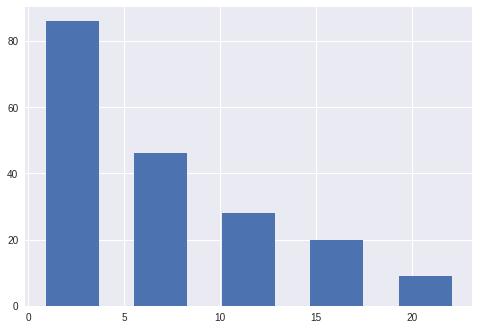

In [0]:
 # Generamos una gráfica con las distribuciones del conjunto de entrenamiento
bins=[-1,0,5,10,15,25]
plt.hist(ds_total["PHQ8_Score"], rwidth=0.6, bins=5)
plt.show()


En la gráfica se visualiza una clara mayoria en la categoria mild cuya puntuación PHQ8 es mayor que 0 y menor que 5


####separación de datasets por puntaje PHQ8

Función que separa los registros del dataset acorde el nivel de ansiedad

In [0]:
def split_by_phq_level(ds):
  none_ds = ds[ds['level']==0]
  mild_ds = ds[ds['level']==1]
  moderate_ds = ds[ds['level']==2]
  moderate_severe_ds = ds[ds['level']==3]
  severe_ds = ds[ds['level']==4]
  return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)


In [0]:
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Cantidad por none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))

Cantidad por none_ds: 26, mild_ds: 70, moderate_ds 47, moderate_severe_ds: 24, severe_ds 22


####Distribución balanceada de los datos del conjunto de prueba

Generamos un dataset con un número de registros balanceado entre todos los niveles de ansiedad

In [0]:
b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])

Fusionamos el dataset de transcripciones con los resultados del test PHQ8

In [0]:
ds_lp = pd.merge(ds_total, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp_b = pd.merge(ds_total_b, phrases_lp,left_on='Participant_ID', right_on='personId')

####método para separar unificar los data sets por niveles, y distribuirlos en conjunto de entrenamiento, validación y pruebas

In [0]:
def distribute_instances(ds):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    split = [70,14,16]
    eq_ds = {}
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0

    for p in split:
      last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
      last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
      last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
      last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
      last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))  
      eq_ds["d"+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
      prev_none = last_none
      prev_mild = last_mild
      prev_moderate = last_moderate
      prev_moderate_severe = last_moderate_severe
      prev_severe = last_severe  
    return (eq_ds["d70"], eq_ds["d14"], eq_ds["d16"])

Generación de conjuntos de entrenamiento, validación y prueba

In [0]:
train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)

##Entrenamiento

Función auxiliar para la generación de la matriz de confusión

In [0]:
def test_model(text, model):
  print(text)
  word_list = text_to_wordlist(text)
  sequences = tokenizer.texts_to_sequences([word_list])
  sequences_input = list(itertools.chain(*sequences))
  sequences_input =  pad_sequences([sequences_input], value=0, padding="post", maxlen=windows_size).tolist()
  input_a = np.asarray(sequences_input)
  pred = model.predict(input_a, batch_size=None, verbose=0, steps=None)
  print(pred)
  predicted_class = np.argmax(pred)
  print(labels[predicted_class])

In [0]:
def confusion_matrix(model, x, y):
  prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
  labels=['none','mild','moderate','moderately severe', 'severe']

  max_prediction = np.argmax(prediction, axis=1)
  max_actual = np.argmax(y, axis=1)

  y_pred = pd.Categorical.from_codes(max_prediction, labels)
  y_actu = pd.Categorical.from_codes(max_actual, labels)

  return pd.crosstab(y_actu, y_pred)
  

####Modelo 1

El primer modelo utiliza el modelo pre entrenado GLObalVEctor que consiste en vectores de 100 elementos que caracterizan para palabra del modelo

Cargamos los embeddings del modelo glove

In [0]:
embeddings_index = dict()
f = open('/content/drive/My Drive/Colab Notebooks/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

Función que genera la matriz de embedding que se utilizará en el entrenamiento del modelo

In [0]:
def fill_embedding_matrix(tokenizer):
  vocab_size = len(tokenizer.word_index)
  embedding_matrix = np.zeros((vocab_size+1, 100))
  for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:        
      embedding_matrix[i] = embedding_vector
  return embedding_matrix

Generamos la matriz para el tokenizer utilizado para generar el dataset de entrenamiento

In [0]:
vocab_size = len(tokenizer.word_index)
embedding_matrix_lp = fill_embedding_matrix(tokenizer)

Preparamos los arrays de entrada al modelo

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
train_a = np.stack(train_lp['t_answer'], axis=0)
dev_a = np.stack(dev_lp['t_answer'], axis=0)
train_y = np.stack(train_lp['cat_level'], axis=0)
dev_y = np.stack(dev_lp['cat_level'], axis=0)

Verificamos las dimensiones de las entradas del modelo

In [0]:
print(embedding_matrix_lp.shape)
print(vocab_size)
print(windows_size)

(7374, 100)
7373
10


### Definición del modelo

Generamos un modelo de embedding con LSTM, dos capas densas intermedias y una capa de salida softmax

In [0]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

bt = BatchNormalization()(answer_emb1)
lstm = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(bt)

dense1 = Dense(units=256, activation="relu")(lstm)
dense2 = Dense(units=256, activation="relu")(dense1)

flatten = Flatten()(dense2)

out = Dense(5,  activation='softmax')(flatten)

model = Model(inputs=[answer_inp], outputs=[out])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 100)           737400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 256)           25856     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 256)           65792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
__________

Entrenamiento del modelo

In [0]:
model_glove_hist = model.fit([train_a], train_y, \
        validation_data=([dev_a], dev_y), \
        epochs=30, batch_size=64, shuffle=True, \
         callbacks=[early_stopping])

Train on 99969 samples, validate on 19993 samples
Epoch 1/30
99969/99969 [==============================] - 71s 707us/step - loss: 1.4421 - acc: 0.3789 - val_loss: 1.3245 - val_acc: 0.4432
Epoch 2/30
99969/99969 [==============================] - 68s 684us/step - loss: 1.2629 - acc: 0.4732 - val_loss: 1.1118 - val_acc: 0.5548
Epoch 3/30
99969/99969 [==============================] - 69s 690us/step - loss: 1.1048 - acc: 0.5498 - val_loss: 0.9342 - val_acc: 0.6322
Epoch 4/30
99969/99969 [==============================] - 68s 684us/step - loss: 0.9946 - acc: 0.6031 - val_loss: 0.8174 - val_acc: 0.6834
Epoch 5/30
99969/99969 [==============================] - 69s 686us/step - loss: 0.9231 - acc: 0.6335 - val_loss: 0.7287 - val_acc: 0.7247
Epoch 6/30
99969/99969 [==============================] - 68s 685us/step - loss: 0.8561 - acc: 0.6621 - val_loss: 0.6669 - val_acc: 0.7566
Epoch 7/30
99969/99969 [==============================] - 69s 688us/step - loss: 0.8038 - acc: 0.6875 - val_loss: 0.

Revisión de la evolución de las funciones de pérdida y la precisión del modelo

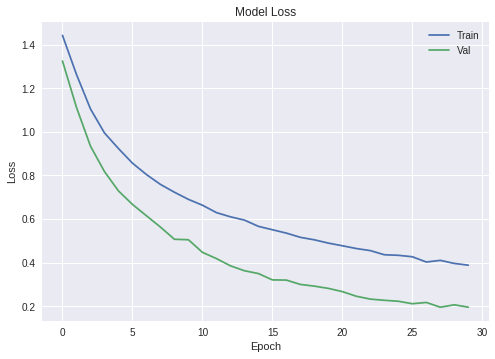

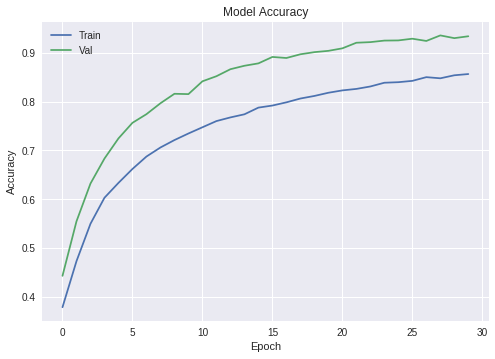

In [0]:
plot_loss(model_glove_hist)
plot_acc(model_glove_hist)

Generación de la matriz de confusión para los datos de prueba

In [45]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
df_confusion = confusion_matrix(model, test_a, test_y)
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3298,128,47,96,24
mild,72,7390,160,161,49
moderate,77,176,5735,151,21
moderately severe,9,41,23,2764,6
severe,21,75,45,70,2210


In [44]:
score = model.evaluate(test_a, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19361946122722712
Test accuracy: 0.936452361153661


In [0]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model)
sen = "I'm afraid of lose my work, I don't have any money"
test_model(sen, model)
sen = "I'm worried about my future, I'm afroid of it"
test_model(sen, model)

All is going right with the party, I'm happy to know new people
[[0.69936794 0.1169407  0.17538027 0.00344947 0.00486151]]
none
I want an ice cream and have some fries for lunch
[[6.8399517e-05 9.9647409e-01 3.4284564e-03 1.4328405e-05 1.4767187e-05]]
mild
I'm afraid of lose my work, I don't have any money
[[0.00329119 0.146804   0.18678905 0.06857509 0.59454066]]
severe
I'm worried about my future, I'm afroid of it
[[0.02175163 0.03142028 0.39687786 0.47654995 0.07340028]]
moderately severe


In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
train_b_a = np.stack(train_lp_b['t_answer'], axis=0)
dev_b_a = np.stack(dev_lp_b['t_answer'], axis=0)
train_b_y = np.stack(train_lp_b['cat_level'], axis=0)
dev_b_y = np.stack(dev_lp_b['cat_level'], axis=0)


In [47]:
model_glove_hist = model.fit([train_b_a], train_b_y, \
        validation_data=([dev_b_a], dev_b_y), \
        epochs=30, batch_size=64, shuffle=True, \
         callbacks=[early_stopping])

Train on 64178 samples, validate on 12835 samples
Epoch 1/30
64178/64178 [==============================] - 43s 674us/step - loss: 0.4125 - acc: 0.8497 - val_loss: 0.0963 - val_acc: 0.9730
Epoch 2/30
64178/64178 [==============================] - 44s 679us/step - loss: 0.3488 - acc: 0.8742 - val_loss: 0.0760 - val_acc: 0.9804
Epoch 3/30
64178/64178 [==============================] - 44s 679us/step - loss: 0.3245 - acc: 0.8835 - val_loss: 0.0739 - val_acc: 0.9797
Epoch 4/30
64178/64178 [==============================] - 44s 679us/step - loss: 0.3035 - acc: 0.8903 - val_loss: 0.0717 - val_acc: 0.9789
Epoch 5/30
64178/64178 [==============================] - 43s 675us/step - loss: 0.2911 - acc: 0.8952 - val_loss: 0.0692 - val_acc: 0.9792
Epoch 6/30
64178/64178 [==============================] - 43s 675us/step - loss: 0.2768 - acc: 0.8991 - val_loss: 0.0637 - val_acc: 0.9815
Epoch 7/30
64178/64178 [==============================] - 43s 676us/step - loss: 0.2704 - acc: 0.9033 - val_loss: 0.

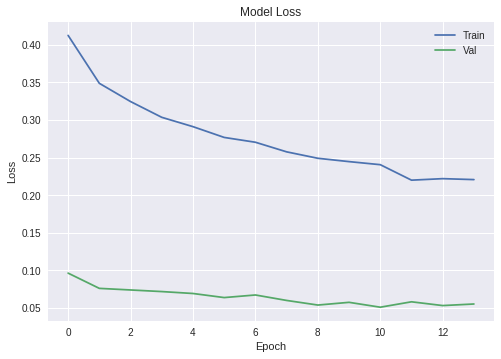

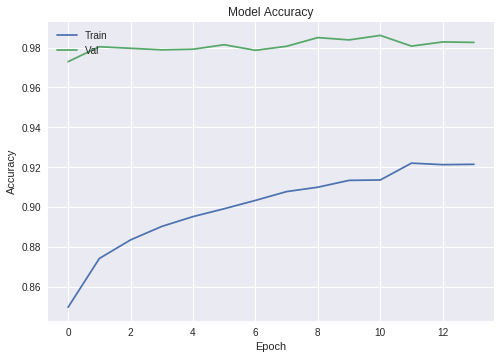

In [48]:
plot_loss(model_glove_hist)
plot_acc(model_glove_hist)

In [50]:
score = model.evaluate(test_a, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.055366958752652934
Test accuracy: 0.9832287973820562


In [49]:
test_a = np.stack(test_lp_b['t_answer'], axis=0)
test_y = np.stack(test_lp_b['cat_level'], axis=0)
df_confusion = confusion_matrix(model, test_a, test_y)
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3501,28,16,37,11
mild,1,2825,7,13,6
moderate,8,24,2895,18,14
moderately severe,5,7,8,2816,7
severe,8,16,7,5,2385


Probamos el modelo con frases de diferente contenido

In [52]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model)
sen = "I'm afraid of lose my work, I don't have any money"
test_model(sen, model)
sen = "I'm worried about my future, I'm afroid of it"
test_model(sen, model)

All is going right with the party, I'm happy to know new people
[[0.91757417 0.04163578 0.02437234 0.00603157 0.01038613]]
none
I want an ice cream and have some fries for lunch
[[2.9371495e-05 9.8760903e-01 1.2255439e-02 8.2105880e-06 9.8008029e-05]]
mild
I'm afraid of lose my work, I don't have any money
[[0.00625332 0.7135069  0.01681946 0.04589701 0.21752344]]
mild
I'm worried about my future, I'm afroid of it
[[0.70848745 0.04342343 0.21481507 0.02298592 0.01028808]]
none


####Modelo 2

El primer modelo utiliza el modelo pre entrenado GLObalVEctor que consiste en vectores de 100 elementos que caracterizan para palabra del modelo

Cargamos el modelo de google news vectors negative mediante el uso de la libreria gensim

In [0]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True)  

Función que genera la matriz de embedding con el tokenizer utilizado para generar el dataset de entrenamiento

In [0]:
def fill_embedding_matrix_google(vocab_size, tokenizer):  
  embedding_matrix = np.zeros((vocab_size+1, 300))  
  for word, i in tokenizer.word_index.items():
      if word in word2vec.vocab:        
          embedding_matrix[i] = word2vec.word_vec(word)        
  return embedding_matrix

In [0]:
embedding_matrix_gg = fill_embedding_matrix_google(vocab_size, tokenizer)

In [0]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = windows_size
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

embedding_layer = Embedding(vocab_size+1,
        EMBEDDING_DIM,
        weights=[embedding_matrix_gg],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)

lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

answer_inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(answer_inp)
x1 = lstm_layer(embedded_sequences_1)

merged = x1
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

out = Dense(5, activation='softmax')(merged)

model_gg_1 = Model(inputs=[answer_inp], outputs=[out])
model_gg_1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = STAMP + '.google.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model_google_hist = model_gg_1.fit([train_b_a], train_b_y, \
        validation_data=([dev_b_a], dev_b_y), \
        epochs=30, batch_size=64, shuffle=True, \
         callbacks=[early_stopping, model_checkpoint])

Train on 65105 samples, validate on 13020 samples
Epoch 1/30
65105/65105 [==============================] - 45s 694us/step - loss: 1.6589 - acc: 0.2717 - val_loss: 1.5059 - val_acc: 0.3367
Epoch 2/30
65105/65105 [==============================] - 43s 668us/step - loss: 1.5138 - acc: 0.3286 - val_loss: 1.4690 - val_acc: 0.3624
Epoch 3/30
65105/65105 [==============================] - 43s 667us/step - loss: 1.4674 - acc: 0.3645 - val_loss: 1.3966 - val_acc: 0.4098
Epoch 4/30
65105/65105 [==============================] - 43s 668us/step - loss: 1.3740 - acc: 0.4226 - val_loss: 1.2622 - val_acc: 0.4768
Epoch 5/30
65105/65105 [==============================] - 43s 668us/step - loss: 1.2222 - acc: 0.5045 - val_loss: 1.0851 - val_acc: 0.5693
Epoch 6/30
65105/65105 [==============================] - 44s 668us/step - loss: 1.0535 - acc: 0.5853 - val_loss: 0.9070 - val_acc: 0.6552
Epoch 7/30
65105/65105 [==============================] - 43s 668us/step - loss: 0.8917 - acc: 0.6569 - val_loss: 0.

In [0]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model_gg_1)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model_gg_1)
sen = "I'm afraid of lose my work, I don't have any money"
test_model(sen, model_gg_1)
sen = "I'm worried about my future, I'm afroid of it"
test_model(sen, model_gg_1)

All is going right with the party, I'm happy to know new people
[[9.9917454e-01 5.5977824e-05 7.0043391e-04 5.8408415e-05 1.0548229e-05]]
none
I want an ice cream and have some fries for lunch
[[1.9910915e-03 9.9590093e-01 1.2515798e-03 1.3596989e-04 7.2039827e-04]]
mild
I'm afraid of lose my work, I don't have any money
[[9.4489747e-05 1.5762453e-04 2.2937744e-03 8.5062720e-02 9.1239142e-01]]
severe
I'm worried about my future, I'm afroid of it
[[3.8276261e-04 1.9378921e-03 7.4735628e-03 3.2245439e-02 9.5796037e-01]]
severe


### Modelo 3

In [0]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = windows_size

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'

STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

embedding_layer = Embedding(vocab_size+1,
        EMBEDDING_DIM,
        weights=[embedding_matrix_lp],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)

lstm_layer1 = LSTM(num_lstm, return_sequences= True, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm) 
lstm_layer2 = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer1(embedded_sequences_1)
merged = lstm_layer2(x1)

merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(5, activation='softmax')(merged)

model_gg_2 = Model(inputs=[sequence_1_input], \
        outputs=preds)

model_gg_2.compile(loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['acc'])  

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
bst_model_path = STAMP + '.google2.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model_google_hist = model_gg_2.fit([train_b_a], train_b_y, \
        validation_data=([dev_b_a], dev_b_y), \
        epochs=30, batch_size=64, shuffle=True, \
         callbacks=[early_stopping, model_checkpoint])

Train on 64178 samples, validate on 12835 samples
Epoch 1/30
64178/64178 [==============================] - 80s 1ms/step - loss: 1.6505 - acc: 0.2514 - val_loss: 1.5817 - val_acc: 0.2547
Epoch 2/30
64178/64178 [==============================] - 78s 1ms/step - loss: 1.5415 - acc: 0.3119 - val_loss: 1.4637 - val_acc: 0.3684
Epoch 3/30
64178/64178 [==============================] - 78s 1ms/step - loss: 1.4276 - acc: 0.3894 - val_loss: 1.2763 - val_acc: 0.4779
Epoch 4/30
64178/64178 [==============================] - 78s 1ms/step - loss: 1.2642 - acc: 0.4838 - val_loss: 1.0798 - val_acc: 0.5710
Epoch 5/30
64178/64178 [==============================] - 78s 1ms/step - loss: 1.1047 - acc: 0.5647 - val_loss: 0.8821 - val_acc: 0.6647
Epoch 6/30
64178/64178 [==============================] - 78s 1ms/step - loss: 0.9725 - acc: 0.6255 - val_loss: 0.7400 - val_acc: 0.7301
Epoch 7/30
64178/64178 [==============================] - 78s 1ms/step - loss: 0.8786 - acc: 0.6638 - val_loss: 0.6313 - val_acc

In [55]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model_gg_2)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model_gg_2)
sen = "I'm afraid of lose my work, I don't have any money"
test_model(sen, model_gg_2)
sen = "I'm worried about my future, I'm afroid of it"
test_model(sen, model_gg_2)

All is going right with the party, I'm happy to know new people
[[0.96240765 0.00927616 0.02295653 0.00381057 0.00154902]]
none
I want an ice cream and have some fries for lunch
[[7.1605165e-03 9.8389721e-01 8.6737942e-04 1.8937162e-03 6.1811777e-03]]
mild
I'm afraid of lose my work, I don't have any money
[[0.03731487 0.01673353 0.19901645 0.01510117 0.73183405]]
severe
I'm worried about my future, I'm afroid of it
[[0.02280828 0.00130085 0.94699836 0.01692226 0.01197031]]
moderate


### Modelo 4

In [0]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
act = 'relu'

embedding_layer = Embedding(vocab_size+1,
        EMBEDDING_DIM,
        weights=[embedding_matrix_lp],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

merged = Dropout(rate_drop_dense)(x1)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds_1 = Dense(5, activation='softmax')(merged)
preds_2 = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input], \
        outputs=[preds_1, preds_2])

model.compile(loss=['categorical_crossentropy', 'mean_squared_error'],
        optimizer='nadam', loss_weights=[1., 0.2],
        metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 10, 100)      737400      input_13[0][0]                   
__________________________________________________________________________________________________
lstm_17 (LSTM)                  (None, 265)          387960      embedding_11[0][0]               
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 265)          0           lstm_17[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [0]:
train_phq_score = train_lp_b['PHQ8_Score'] 
dev_phq_score = dev_lp_b['PHQ8_Score'] 
test_phq_score = test_lp_b['PHQ8_Score'] 

In [0]:
early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.twolosses.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([train_b_a], [train_b_y, train_phq_score], \
        validation_data=([dev_b_a], [dev_b_y, dev_phq_score]), \
        epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 66771 samples, validate on 13354 samples
Epoch 1/30
66771/66771 [==============================] - 51s 767us/step - loss: 19.1457 - dense_16_loss: 1.6423 - dense_17_loss: 87.5170 - dense_16_acc: 0.2572 - dense_17_acc: 0.0237 - val_loss: 19.0494 - val_dense_16_loss: 1.5619 - val_dense_17_loss: 87.4372 - val_dense_16_acc: 0.2885 - val_dense_17_acc: 0.0207
Epoch 2/30
66771/66771 [==============================] - 49s 729us/step - loss: 18.9756 - dense_16_loss: 1.5501 - dense_17_loss: 87.1278 - dense_16_acc: 0.3012 - dense_17_acc: 0.0198 - val_loss: 18.9897 - val_dense_16_loss: 1.5024 - val_dense_17_loss: 87.4365 - val_dense_16_acc: 0.3388 - val_dense_17_acc: 0.0207
Epoch 3/30
66771/66771 [==============================] - 48s 718us/step - loss: 18.9106 - dense_16_loss: 1.4853 - dense_17_loss: 87.1265 - dense_16_acc: 0.3526 - dense_17_acc: 0.0198 - val_loss: 18.8752 - val_dense_16_loss: 1.3879 - val_dense_17_loss: 87.4364 - val_dense_16_acc: 0.4206 - val_dense_17_acc: 0.0207
Epoch

In [0]:
def test_model_1(text, model):
  print(text)
  word_list = text_to_wordlist(text)
  sequences = tokenizer.texts_to_sequences([word_list])
  sequentes_input = list(itertools.chain(*sequences))
  sequentes_input =  pad_sequences([sequentes_input], value=0, padding="post", maxlen=windows_size).tolist()
  input_a = np.asarray(sequentes_input)
  pred = model.predict(input_a, batch_size=None, verbose=0, steps=None)
  print(pred)
  predicted_class = np.argmax(pred[0])
  print(labels[predicted_class])

In [58]:
sen = "All is going right with the party, I'm happy to know new people"
test_model_1(sen, model)
sen = "I want an ice cream and have some fries for lunch"
test_model_1(sen, model)
sen = "I'm afraid of lose my work, I don't have any money"
test_model_1(sen, model)
sen = "I'm worried about my future, I'm afraid of it"
test_model_1(sen, model)

All is going right with the party, I'm happy to know new people
[[0.91757417 0.04163578 0.02437234 0.00603157 0.01038613]]
none
I want an ice cream and have some fries for lunch
[[2.9371495e-05 9.8760903e-01 1.2255439e-02 8.2105880e-06 9.8008029e-05]]
mild
I'm afraid of lose my work, I don't have any money
[[0.00625332 0.7135069  0.01681946 0.04589701 0.21752344]]
mild
I'm worried about my future, I'm afraid of it
[[0.00097065 0.8856027  0.0748821  0.0059364  0.03260815]]
mild
